# Graph Characteristics

## Board Characteristics

- $6 \times 6$ Matrix
- Each square contains a number/color combination (eg. 1, Blue)
- Because it is a $6 \times 6$ matrix we chose numbers 1-6 and six colors, namely (blue, pink, white, green, red, & yellow)
- We use every possible permutation of the number/color combination to give us $6^2$ squares.

## Node Characteristics
- Tile Number
- Node Color
- Node Number

## Edge Characteristics
- Edge exists iff 
    - same node number
    - same node color
    - both nodes exist on same x or y axis

### Let's get some basic imports out of the way

In [67]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

## Next, We structure our squares, tiles, and boards so we can visualize the boards.

## We also go ahead and hard code the actual blackside of microrobots board.

In [200]:
class Square:
    def __init__(self, color, number):
        self.color = color
        self.number = number
        
class Tile:
    def __init__(self, tile_number, matrix):
        self.number = tile_number
        # TODO: check if perfect square?
        self.matrix = matrix
    
    # since we always have a matrix and to make future operations simpler, we adjust 
    # to return the integer which, when squared, forms the size of our matrix
    def get_shape(self):
        return self.matrix.shape[0]
    
    def print_tile(self):
        for row in self.matrix:
            for cell in row:
                print(cell.color, end=' ')
                print(cell.number, end=' ')
            print("\n")
            
    def print_tile_row(self, row):
        for cell in self.matrix[row]:
            print(cell.color, end=' ')
            print(cell.number, end=' | ')
            
    def get_tile_row(self, row):
        return self.matrix[row]

class Board:
    def __init__(self, matrix):
        # constructor will accept a matrix of Tiles.
        self.matrix = matrix
        self.graph = nx.Graph()
        # TODO: check if perfect square?
        
    def print_board(self):
        tile_shape = self.matrix[0][0].get_shape()
        
        for x in range(tile_shape):
            self.matrix[0][0].print_tile_row(x)
            self.matrix[0][1].print_tile_row(x)
            print("\n")
         
        for x in range(tile_shape):
            self.matrix[1][0].print_tile_row(x)
            self.matrix[1][1].print_tile_row(x)
            print("\n")
    
    # deconstructs the board into a matrix of squares
    def deconstruct_board(self):
        tile_shape = self.matrix[0][0].get_shape()
        deconstructed_matrix = []
        for x in range(tile_shape):
            row = np.concatenate([self.matrix[0][0].get_tile_row(x), self.matrix[0][1].get_tile_row(x)])
            deconstructed_matrix.append(row)
            
        for x in range(tile_shape):
            row = np.concatenate([self.matrix[1][0].get_tile_row(x), self.matrix[1][1].get_tile_row(x)])
            deconstructed_matrix.append(row)
            
        return deconstructed_matrix
    
def build_actual_blackside_microrobots_board():
    tileOne = Tile(1, np.array([[Square("W", 6), Square("B", 6), Square("B", 2)],
             [Square("R", 3), Square("Y", 4),Square("W", 3)],
             [Square("B", 3), Square("G", 4), Square("W", 5)]], dtype=np.object).reshape(3,3))

    tileTwo = Tile(2, np.array([[Square("P", 5), Square("P", 2), Square("P", 3)],
                 [Square("R", 6), Square("R", 4),Square("Y", 3)],
                 [Square("B", 4), Square("G", 5), Square("G", 3)]], dtype=np.object).reshape(3,3))

    tileThree = Tile(3, np.array([[Square("B", 1), Square("R", 2), Square("W", 4)],
                 [Square("W", 1), Square("G", 2),Square("G", 6)],
                 [Square("Y", 2), Square("W", 2), Square("P", 4)]], dtype=np.object).reshape(3,3))

    tileFour = Tile(4, np.array([[Square("P", 1), Square("Y", 6), Square("Y", 1)],
                 [Square("Y", 5), Square("B", 5),Square("R", 5)],
                 [Square("P", 6), Square("R", 1), Square("G", 1)]], dtype=np.object).reshape(3,3))

    return Board(np.array([[tileOne, tileTwo], [tileThree, tileFour]], dtype=np.object).reshape(2,2))

blackside_board = build_actual_blackside_microrobots_board()

blackside_board.print_board()


W 6 | B 6 | B 2 | P 5 | P 2 | P 3 | 

R 3 | Y 4 | W 3 | R 6 | R 4 | Y 3 | 

B 3 | G 4 | W 5 | B 4 | G 5 | G 3 | 

B 1 | R 2 | W 4 | P 1 | Y 6 | Y 1 | 

W 1 | G 2 | G 6 | Y 5 | B 5 | R 5 | 

Y 2 | W 2 | P 4 | P 6 | R 1 | G 1 | 



## Now, we implement the ability to generate random boards

In [73]:
# takes n numbers and n colors and generates a random n x n microrobots board
def generate_random_board(numbers, colors):
        # TODO check if lists are equal in size, error if not
        # TODO generalize to n x n by defining tile size rather than just using 3x3
        
        # build hashmap to store numbers and colors
        expected_matrix_size = len(numbers) * len(colors)
        hashmap = {}
        for color in colors:
            hashmap[color] = []
            for num in numbers:
                hashmap[color].append(num)
        
        
        # generates a random unique (exactly once) set of combinations of 
        # numbers and colors and returns them as an instance of Square
        squares = []
        while len(colors) > 0:
            # chose random color
            rand_color = random.choice(colors)
            rand_num = random.choice(hashmap[rand_color])
            hashmap[rand_color].pop(hashmap[rand_color].index(rand_num))
            
            squares.append(Square(rand_color, rand_num))
            
            # now we check if we used last num, if so remove color
            # care, this is terminating condition on while loop
            if len(hashmap[rand_color]) == 0:
                colors.pop(colors.index(rand_color))

                
        # doouble check if len is as expected
        if len(squares) != expected_matrix_size:
            print("ERROR: You only produced ", len(squares), "squares and we expected", expected_matrix_size)
            return
        
        # generate 4 arrays of 9 
        # TODO: the generation of these tiles is obvious not, itself, random. need to decide if this matters
        split_squares = np.array_split(squares, 4)
        board = Board(np.array([[Tile(1, split_squares[0].reshape(3,3)), Tile(2,split_squares[1].reshape(3,3))],
                 [Tile(3,split_squares[0].reshape(3,3)), Tile(4, split_squares[1].reshape(3,3))]], dtype=np.object).reshape(2,2))
        
        return board            
            
random_board = generate_random_board([1,2,3,4,5,6], ["W", "R", "B", "P", "Y", "G"])
random_board.print_board()



R 1 | B 3 | R 3 | R 5 | P 2 | W 1 | 

Y 1 | W 3 | P 6 | W 5 | R 6 | W 6 | 

G 1 | R 2 | Y 4 | G 3 | G 6 | G 4 | 

R 1 | B 3 | R 3 | R 5 | P 2 | W 1 | 

Y 1 | W 3 | P 6 | W 5 | R 6 | W 6 | 

G 1 | R 2 | Y 4 | G 3 | G 6 | G 4 | 



#### Now, let's explore the connectedness of a board.
##### We consider two squares connected iff
    - They exist on the same row OR column AND
    - They are the the same color OR number

Graph characteristics: 
36 nodes
58 edges
Connected? True


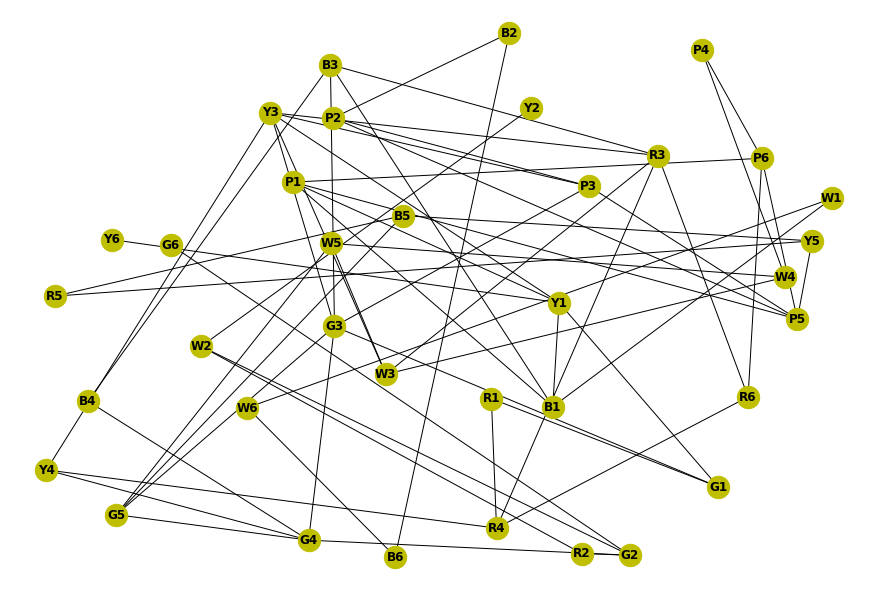

W6 --> ['W1', 'B6']
B6 --> ['W6', 'B2']
B2 --> ['B6', 'P2']
P5 --> ['P1', 'Y5', 'P6', 'P2', 'P3']
P2 --> ['B2', 'P5', 'P3']
P3 --> ['P5', 'P2', 'Y3', 'G3']
R3 --> ['B3', 'W3', 'R6', 'R4', 'Y3']
Y4 --> ['G4', 'R4', 'Y3']
W3 --> ['R3', 'W5', 'W4', 'Y3']
R6 --> ['R3', 'P6', 'R4']
R4 --> ['R3', 'Y4', 'R6', 'R1']
Y3 --> ['P3', 'R3', 'Y4', 'W3', 'G3', 'Y1']
B3 --> ['R3', 'B1', 'B4', 'G3']
G4 --> ['Y4', 'G2', 'B4', 'G5', 'G3']
W5 --> ['W3', 'W4', 'G5']
B4 --> ['B3', 'G4']
G5 --> ['G4', 'W5', 'B5', 'G3']
G3 --> ['P3', 'Y3', 'B3', 'G4', 'G5', 'G1']
B1 --> ['B3', 'W1', 'P1', 'Y1']
R2 --> ['G2', 'W2']
W4 --> ['W3', 'W5', 'P4']
P1 --> ['P5', 'B1', 'P6', 'Y1']
Y6 --> ['Y1']
Y1 --> ['Y3', 'B1', 'P1', 'Y6', 'G1']
W1 --> ['W6', 'B1']
G2 --> ['G4', 'R2', 'W2', 'G6']
G6 --> ['G2']
Y5 --> ['P5', 'B5', 'R5']
B5 --> ['G5', 'Y5', 'R5']
R5 --> ['Y5', 'B5']
Y2 --> ['W2']
W2 --> ['R2', 'G2', 'Y2']
P4 --> ['W4', 'P6']
P6 --> ['P5', 'R6', 'P1', 'P4']
R1 --> ['R4', 'G1']
G1 --> ['G3', 'Y1', 'R1']


In [199]:
# get matrix deconstruction
deconstructed_matrix = np.array(blackside_board.deconstruct_board()).reshape(6,6)
G = nx.Graph()

# make each square a graph node
for row in deconstructed_matrix:
    for elem in row:
        label = elem.color + str(elem.number)
        G.add_node(elem, label=label)

# for each node
for row_index, row in enumerate(deconstructed_matrix, start=0):
        for col_index, elem in enumerate(row, start=0):
            # examine column, if same number or color, create an edge between the two nodes 
            # library handles case of duplicate edges
            for square in deconstructed_matrix[:,col_index]:
                if(square.color == elem.color or square.number == elem.number):
                    G.add_edge(square,elem)
                    
            # examine row, if same number or color, create an edge between the two nodes 
            # library handles case of duplicate edges
            for square in deconstructed_matrix[row_index]:
                if(square.color == elem.color or square.number == elem.number):
                    G.add_edge(square,elem)
                    
G.remove_edges_from(nx.selfloop_edges(G))

print("Graph characteristics: ")
print(G.number_of_nodes(), "nodes")
print(G.number_of_edges(), "edges")
print("Connected?", nx.is_connected(G))

pos = nx.spring_layout(G,k=0.75,iterations=20)

plt.figure(3,figsize=(12,8))
nx.draw(G,pos, labels=labels, node_size=500, font_weight='bold', node_color='y')
plt.show()

adjacency_dict = {}

for n, nbrdict in G.adjacency():
    adjacency_dict[n.color + str(n.number)] = []
    for item in nbrdict:
        adjacency_dict[n.color + str(n.number)].append(item.color + str(item.number))
    
#print adjancecy dict for verfication of correctness
for k, v in adjacency_dict.items():
    print (k, '-->', v)
    

### Next, we examine all of the different permutations of the actual board graph and verify they are all connected